In [1]:
%matplotlib inline
import json
import matplotlib.pyplot as plt
import numpy as np

with open('varsity-blues.json', 'r') as f:
    data = json.loads(f.read())

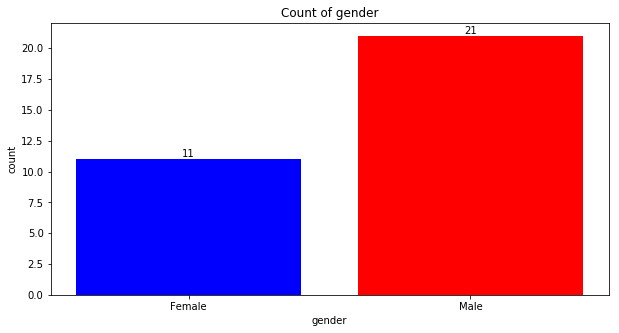

In [2]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.00*height,
                '%d' % int(height),
                ha='center', va='bottom')
        
genders = [individual['gender'] 
           for item in data 
           for individual in item['individual']]

num_females = sum(map(lambda g: 1 if g == 'F' else 0, genders))
num_males = sum(map(lambda g: 1 if g == 'M' else 0, genders))

gender_data = [num_females, num_males]
ind = np.arange(len(gender_data))
bars = ('Female', 'Male')

fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(ind, gender_data, color=['blue', 'red'])
ax.set_title('Count of gender')
ax.set_ylabel('count')
ax.set_xlabel('gender')
ax.set_xticks(ind)
ax.set_xticklabels(bars)
autolabel(rects)

min age = 48, max age = 86, average age = 56.94


Text(0.5, 0, 'age')

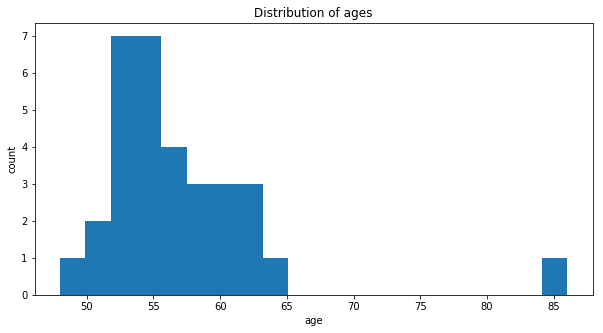

In [3]:
ages = [individual['age'] 
           for item in data 
           for individual in item['individual']]

min_age = min(ages)
max_age = max(ages)
avg_age = np.average(ages)

print('min age = {}, max age = {}, average age = {:.2f}'.format(
    min_age, max_age, avg_age))

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(ages, bins=20)
ax.set_title('Distribution of ages')
ax.set_ylabel('count')
ax.set_xlabel('age')

Text(0.5, 1.0, 'Gender and age distribution')

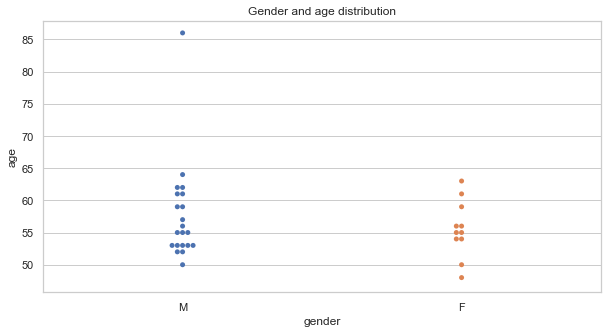

In [4]:
import pandas as pd
import seaborn as sns

sns.set(style="whitegrid")

demographics = pd.DataFrame({'age': ages, 'gender': genders})

fig, ax = plt.subplots(figsize=(10, 5))
sns.swarmplot(x='gender', y='age', data=demographics, ax=ax)
ax.set_title('Gender and age distribution')

In [5]:
first_names = [individual['first_name'].lower()
           for item in data 
           for individual in item['individual']]
last_names = [individual['last_name'].lower()
           for item in data 
           for individual in item['individual']]
names = []
names.extend(first_names)
names.extend(last_names)
names.extend(['bill'])

In [6]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.corpora.dictionary import Dictionary
from gensim import models

def get_profile(documents):
    frequency = {}
    for text in documents:
        tokens = [t.lower() for t in word_tokenize(text)]
        for word in tokens:
            if word not in frequency:
                frequency[word] = 0
            frequency[word] = frequency[word] + 1
    return frequency

def clean(text, profile, stop_words, stemmer):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens]
    tokens = [word for word in tokens if profile[word] > 1]
    tokens = [word for word in tokens if not word in stop_words]
    if stemmer is not None:
        tokens = [stemmer.stem(word) for word in tokens]
    tokens = [word for word in tokens if not word in stop_words]
    return tokens


stop_words = stopwords.words('english')
stop_words.extend(['else', 'onto', 'said', 'someone', 'live', 
                   'designate', 'work', 'say', 'port', 'available',
                   'place', 'home', 'world', 'ye', 'yesterday', 'one',
                   'also', 'with', 'get', 'wit', 'way', 'marri', 'former',
                   'willki', 'phone', 'record', 'new', 'hundr', 'dollar',
                   'cooperating', 'document', 'quot'
                  ])
stop_words.extend(names)

stemmer = PorterStemmer()

documents = [item['description'] for item in data]
profile = get_profile(documents)
texts = [clean(d, profile, stop_words, stemmer) for d in documents]
unstemmed_texts = [clean(d, profile, stop_words, None) for d in documents]

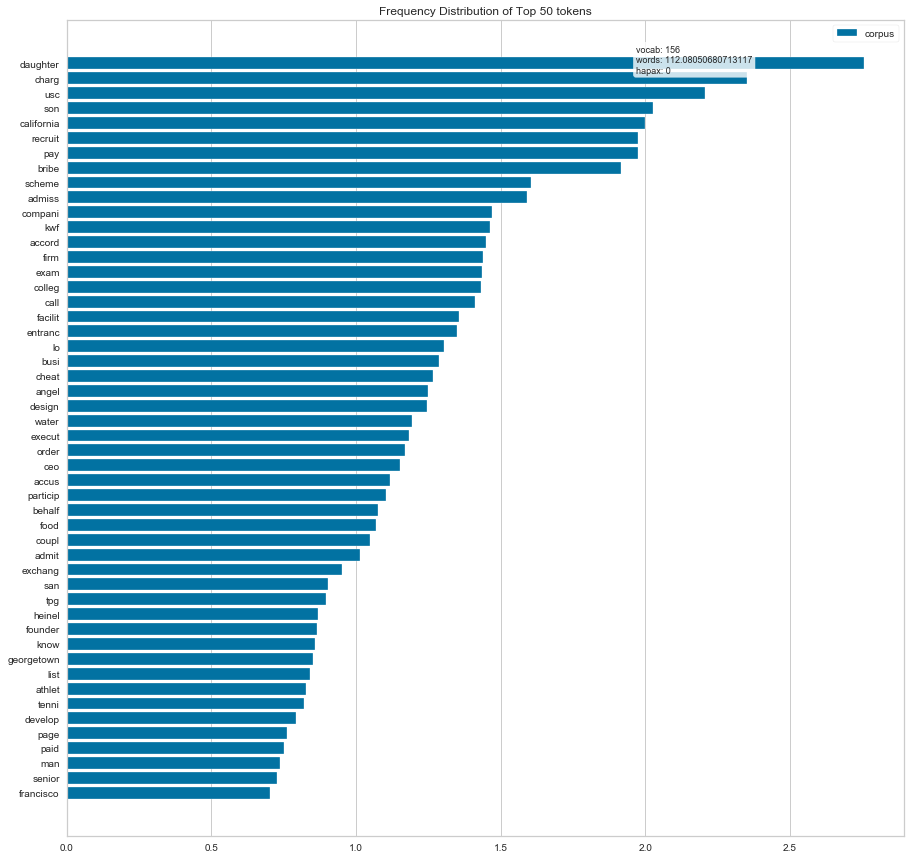

['accord', 'accus', 'act', 'actress', 'administr', 'admiss', 'admit', 'allegedli', 'angel', 'answer', 'applic', 'ask', 'athlet', 'basketbal', 'beach', 'behalf', 'bloomberg', 'bribe', 'busi', 'california', 'call', 'capit', 'ceo', 'chairman', 'charg', 'cheat', 'citi', 'claim', 'class', 'coach', 'colleg', 'committe', 'compani', 'concern', 'conspiraci', 'correct', 'coupl', 'court', 'crew', 'daughter', 'dentistri', 'design', 'develop', 'diego', 'distilleri', 'distribut', 'donna', 'dragon', 'east', 'entranc', 'equiti', 'ernst', 'estat', 'exam', 'exchang', 'execut', 'facebook', 'facilit', 'fals', 'falsifi', 'farr', 'firm', 'food', 'found', 'foundat', 'founder', 'francisco', 'fraud', 'fraudul', 'gallagh', 'georgetown', 'global', 'go', 'gordi', 'got', 'grade', 'growth', 'heinel', 'help', 'hercul', 'hyanni', 'intern', 'invest', 'investor', 'know', 'kwf', 'la', 'laguna', 'leav', 'like', 'linkedin', 'list', 'lo', 'maci', 'mainten', 'man', 'manag', 'market', 'matter', 'menlo', 'miami', 'midwest', '

In [7]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

merged_text = [' '.join(text) for text in texts]

vectorizer = TfidfVectorizer()
docs       = vectorizer.fit_transform(merged_text)
features   = vectorizer.get_feature_names()

fig, ax = plt.subplots(figsize=(15, 15))
visualizer = FreqDistVisualizer(features=features)
visualizer.fit(docs)
visualizer.poof(ax=ax)
print(features)

In [8]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

num_topics = 10
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics)
corpus_lsi = lsi[corpus_tfidf]

lsi.print_topics(num_topics)

[(0,
  '-0.166*"water" + -0.150*"angel" + -0.148*"son" + -0.143*"lo" + -0.142*"busi" + -0.139*"exchang" + -0.138*"accord" + -0.134*"execut" + -0.133*"particip" + -0.132*"admiss"'),
 (1,
  '0.477*"busi" + 0.265*"publicli" + 0.226*"behalf" + 0.203*"menlo" + 0.202*"park" + 0.182*"entranc" + 0.173*"exam" + 0.173*"food" + 0.169*"particip" + 0.152*"colleg"'),
 (2,
  '-0.437*"water" + -0.230*"polo" + -0.219*"angel" + -0.203*"lo" + -0.191*"tpg" + 0.172*"heinel" + 0.157*"busi" + 0.142*"allegedli" + -0.141*"admit" + 0.131*"help"'),
 (3,
  '-0.272*"angel" + -0.246*"lo" + -0.237*"maci" + -0.231*"actress" + 0.201*"water" + 0.187*"hyanni" + -0.184*"fraudul" + -0.181*"unclear" + 0.176*"develop" + 0.175*"admit"'),
 (4,
  '-0.271*"basketbal" + -0.265*"senior" + -0.256*"tpg" + 0.200*"maci" + -0.187*"vega" + -0.187*"nevada" + -0.187*"la" + -0.169*"execut" + 0.165*"angel" + 0.156*"coupl"'),
 (5,
  '-0.314*"exchang" + 0.302*"tenni" + 0.235*"georgetown" + 0.216*"ernst" + 0.216*"coach" + -0.189*"heinel" + 0.

In [9]:
def scatter_plot_lsi(df, x1, x2):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(df[x1], df[x2])
    ax.set_title('{} vs {}'.format(x1, x2))
    ax.set_xlabel(x1)
    ax.set_ylabel(x2)
    
    for i, name in enumerate(df['name']):
        x = df.iloc[i][x1]
        y = df.iloc[i][x2]
        ax.annotate(name, (x, y))
        
def lsi_to_df(corpus_lsi, data, num_topics):
    d = {}
    for i in range(num_topics):
        k = 'x{}'.format(i)
        v = [doc[i][1] for doc in corpus_lsi]
        d[k] = v
        i += 1
    d['name'] = [str(i) + '-' + item['individual'][0]['last_name'] for i, item in enumerate(data)]
    d['description'] = [item['description'] for item in data]
    return pd.DataFrame(d)

lsi_data = lsi_to_df(corpus_lsi, data, num_topics)

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def get_sil_avg(df, n_clusters):
    cols = [c for c in df.columns if c.startswith('x')]
    X = df[cols].values

    kmeans = KMeans(n_clusters=n_clusters, random_state=37).fit(X)
    labels = kmeans.fit_predict(X)

    sil_avg = silhouette_score(X, labels)
    return sil_avg

for n_clusters in range(2, 21, 1):
    sil_avg = get_sil_avg(lsi_data, n_clusters)
    print('{}: {:.5f}'.format(n_clusters, sil_avg))

2: 0.07461
3: 0.10844
4: 0.12048
5: 0.13655
6: 0.18376
7: 0.21279
8: 0.24324
9: 0.28335
10: 0.26211
11: 0.28091
12: 0.29355
13: 0.28744
14: 0.25382
15: 0.25390
16: 0.24502
17: 0.22373
18: 0.21460
19: 0.20152
20: 0.18656


0 : 1 : 1-Huneeus
0 : 5 : 5-Buckingham
0 : 14 : 14-Blake
0 : 19 : 19-Palatella
1 : 7 : 7-Abbott
1 : 20 : 20-Jan Sartorio
2 : 0 : 0-McGlashan
2 : 13 : 13-Abdelaziz
2 : 18 : 18-MacFarlane
3 : 11 : 11-Huffman
3 : 12 : 12-Giannulli
3 : 15 : 15-Colburn
4 : 2 : 2-Hodge
4 : 4 : 4-Flaxman
4 : 6 : 6-Caplan
4 : 8 : 8-Zangrillo
5 : 23 : 23-Sloane
5 : 24 : 24-Wilson
6 : 3 : 3-Henriquez
6 : 9 : 9-Semprevivo
6 : 16 : 16-Kimmel
7 : 21 : 21-Chen
7 : 22 : 22-Klapper
8 : 10 : 10-Isackson
8 : 17 : 17-Janavs
9 : 25 : 25-Zadeh


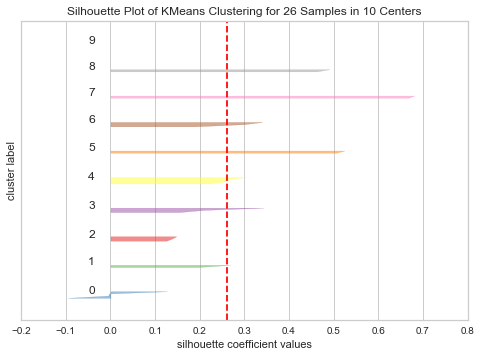

In [11]:
from yellowbrick.cluster import SilhouetteVisualizer

cols = [c for c in lsi_data.columns if c.startswith('x')]
X = lsi_data[cols].values

kmeans = KMeans(n_clusters=10, random_state=37).fit(X)
labels = kmeans.fit_predict(X)
tups = [(label, i, lsi_data.iloc[i]['name']) for i, label in enumerate(labels)]
tups = sorted(tups, key=lambda tup: tup[0])

for tup in tups:
    print('{} : {} : {}'.format(tup[0], tup[1], tup[2]))
    
# kmeans = KMeans(n_clusters=10, random_state=37)
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(X)
visualizer.poof()

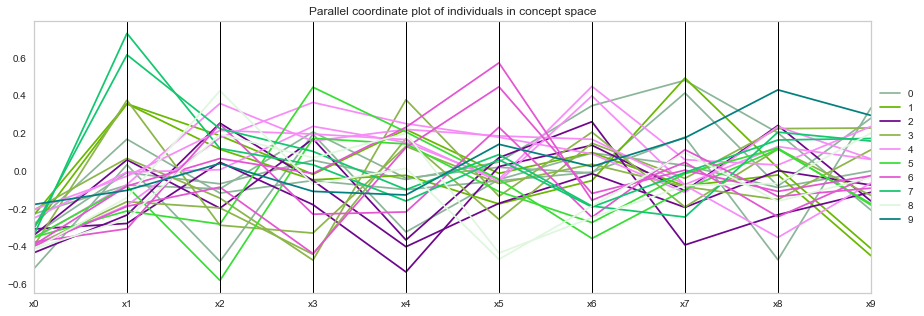

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
cols = [c for c in lsi_data.columns if c.startswith('x')]
lsi_df = lsi_data[cols].copy()
lsi_df['cluster'] = labels
lsi_df = lsi_df.sort_values(by=['cluster'])

pd.plotting.parallel_coordinates(lsi_df, 'cluster', ax=ax)
ax.set_title('Parallel coordinate plot of individuals in concept space')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

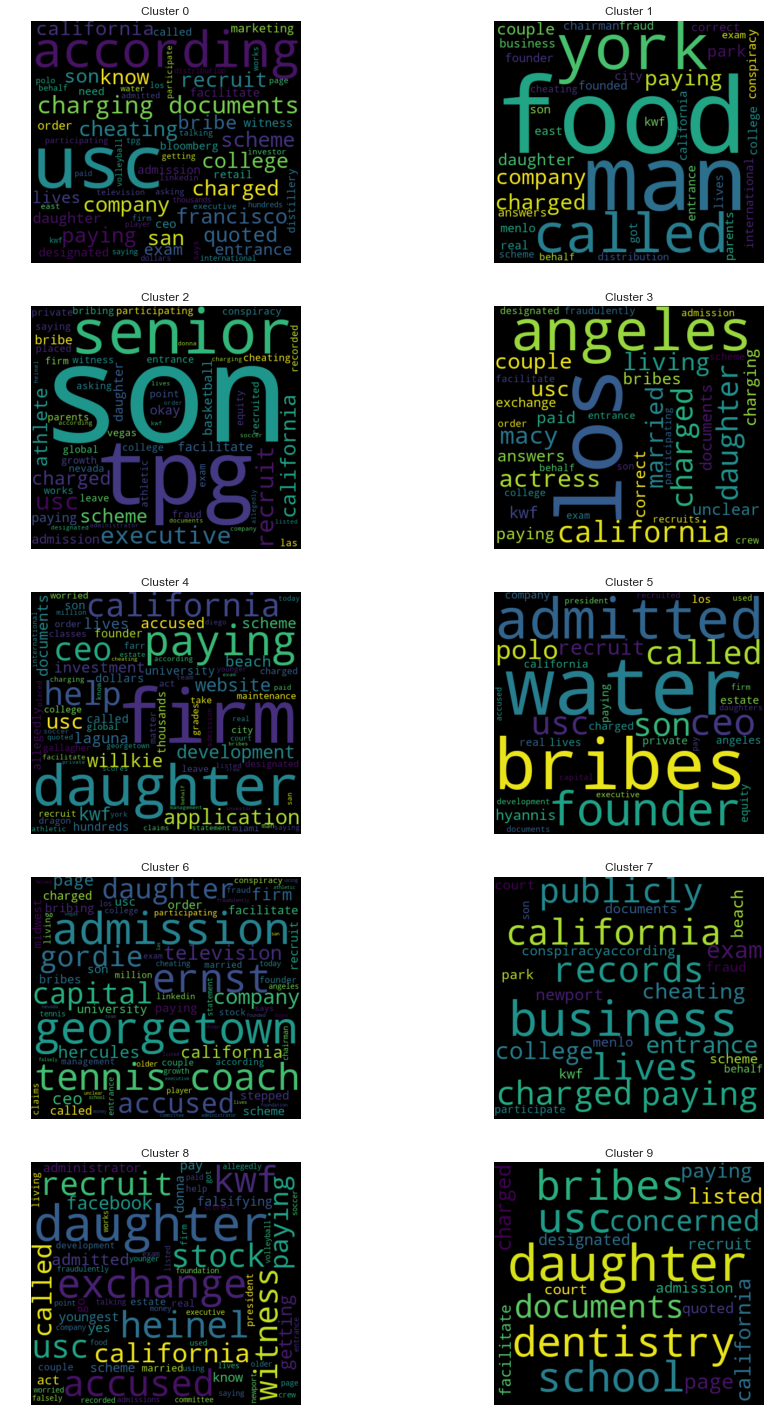

In [13]:
from wordcloud import WordCloud

def get_texts(cluster, texts, tups):
    cluster_tups = filter(lambda tup: tup[0] == cluster, tups)
    cluster_texts = map(lambda tup: texts[tup[1]], cluster_tups)
    cluster_texts = map(lambda arr: ' '.join(arr), cluster_texts)
    return ' '.join(cluster_texts)

fig, ax = plt.subplots(5, 2, figsize=(15, 20))
ax = np.ravel(ax)

for cluster in range(10):
    cluster_text = get_texts(cluster, unstemmed_texts, tups)
    wordcloud = WordCloud(width=500, height=450).generate(cluster_text)
    ax[cluster].imshow(wordcloud, interpolation='bilinear')
    ax[cluster].axis('off')
    ax[cluster].set_title('Cluster {}'.format(cluster))
plt.tight_layout()

In [14]:
import gensim 
from gensim.models import Word2Vec 

emb_model = gensim.models.Word2Vec(texts, min_count = 3, size = 500, window = 50)

In [15]:
for word in ['bribe', 'usc', 'georgetown', 'tpg', 'kwf', 'coach', 'son', 'daughter', 'cheat', 'pay']:
    results = emb_model.wv.most_similar(positive=[word], topn=2)
    print('{}'.format(word))
    for result in results:
        print(' {}: {:.5f}'.format(result[0], result[1]))

bribe
 son: 0.14327
 behalf: 0.13934
usc
 busi: 0.15870
 daughter: 0.15869
georgetown
 scheme: 0.11602
 ceo: 0.11407
tpg
 exchang: 0.15246
 know: 0.14629
kwf
 scheme: 0.15199
 websit: 0.12454
coach
 firm: 0.14222
 worri: 0.13402
son
 pay: 0.16824
 real: 0.14521
daughter
 beach: 0.20995
 firm: 0.18602
cheat
 pay: 0.17821
 firm: 0.15011
pay
 cheat: 0.17821
 privat: 0.17046


# References

* [Get To Know The Rich Assholes Charged With Paying Millions In Bribes To Get Their Kids Into College ](https://deadspin.com/get-to-know-the-rich-assholes-charged-with-paying-milli-1833244052)